# 1. Analýza hlavních komponent (PCA)

V tomto příkladu budeme vycházet ze stejného datového setu, jako při výpočtu lineární regrese. 

Připoměňme si, že do na základě korelační matice, jsme do modelu vybrali proměnné RM, LSTAT a vysvětlovanou proměnnou MEDV.

Vytvořený model měl na trénovacích a testovacích datech R2 skóre přibližně 0,65.

Pomocí PCA se pokusíme dosáhnout lepšího výsledku, tedy vytvořit model, který bude lépe předpovídat.

## 1.1 Načtení a analýza dat

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv ("..\\dataset\\HousingData.csv")

In [3]:
data=data.dropna()

Měřítka proměnných se od sebe velmi liší, a proto budeme muset změnit měřítko našich dat, abychom zlepšili jejich kvalitu, protože na tato data nemůžeme použít PCA nebo lineární regresi.

## 1.2 Lineární model všech proměnných bez úprav
Vytvoříme kontrolní lineární model se všemi proměnnými

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [7]:
# Rozdělení dat na tréninková a testovací
X = np.array(data.drop('MEDV',axis=1))
Y = np.array(data['MEDV'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [8]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [9]:
# Posouzení modelu pro trénovací data
Y_pred = lr.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")

R2 score: 0.6538563209035796
RMSE: 6.283994575517216


In [10]:
# Posouzení modelu pro trénovací data
Y_pred = lr.predict(X_train)
r2 = r2_score(Y_train, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))

print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")

R2 score: 0.8009630215382623
RMSE: 3.859352728570366


## 1.3 Korelace

<Axes: >

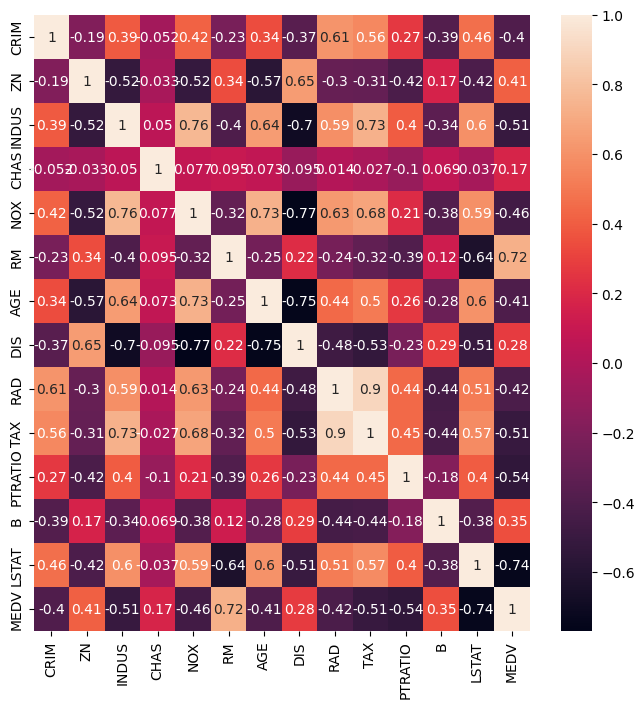

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
sns.heatmap(data.corr(),annot=True)

**Korelační matice** - důležitý je poslední řádek, který nám ukazuje lineární korelaci vysvětlujících proměnných a vysvětlované proměnné MEDV. Zdá se, že naše cílová proměnná je vysoce korelovaná s LSTAT a RM, což dává smysl, protože tyto dva faktory jsou velmi důležité pro tvorbu cen domů, ale zdá se, že je zde také mnoho multikolinearity.

Problém je v tom, že **mezi našimi predikčními proměnnými existuje mnoho kolinearit**, například DIS je vysoce korelován s INUDS, INOX a AGE.

To není dobré, protože **multikolinearita** může náš model učinit nestabilním.

Musíme se na to podívat trochu více, než začneme modelovat naše data. 

V případě přítomnosti multikolinearity bývá odhad vlivu jedné proměnné na závislou proměnnou Y při kontrole ostatních proměnných méně přesný, než kdyby prediktory nebyly vzájemně korelovány.

Obvyklá interpretace regresního koeficientu je taková, že poskytuje odhad účinku jednotkové změny nezávislé proměnné při zachování ostatních proměnných jako konstantních.

Pokud je X1 v daném souboru dat silně korelována s jinou nezávislou proměnnou, X2, pak máme soubor pozorování, pro který X1 a X2 mají určitý lineární stochastický vztah.

## 1.4 Faktor inflace rozptylu (VIF) 

**Faktor inflace rozptylu (VIF)** detekuje multikolinearitu v regresní analýze. O multikolinearitě hovoříme tehdy, když v modelu existuje korelace mezi prediktory (tj. nezávislými proměnnými)

Její přítomnost může negativně ovlivnit výsledky regrese. VIF odhaduje, jak moc je rozptyl regresního koeficientu nadsazen v důsledku multikolinearity v modelu.

VIF=1/(1−R^2)

Kde R^2 je koeficient determinace. Zjednodušeně řečeno, je to podíl rozptylu nezávislé proměnné, který je vysvětlen závislou proměnnou. 

Provedeme tedy lineární regresi s použitím každé proměnné jako cíle a ostatních jako prediktorů a vypočítáme R^2 a poté pro ně vypočítáme VIF.

Pokud je VIF < 4, lze ji použít, v opačném případě musíme najít způsob, jak odstranit kolinearitu těchto funkcí.

In [12]:
# Výpočet VIF pro každou proměnnou
vifdf = []
for i in data.columns:
    X = np.array(data.drop(i,axis=1))
    y = np.array(data[i])
    lr = LinearRegression()
    lr.fit(X,y)
    y_pred = lr.predict(X)
    r2 = r2_score(y,y_pred)
    vif = 1/(1-r2)
    vifdf.append((i,vif))

vifdf = pd.DataFrame(vifdf,columns=['Features','Variance Inflation Factor'])
vifdf.sort_values(by='Variance Inflation Factor')

,Features,Variance Inflation Factor
3,CHAS,1.094393
11,B,1.410486
0,CRIM,1.782836
10,PTRATIO,2.012261
1,ZN,2.392337
5,RM,2.566120
6,AGE,3.180587
12,LSTAT,3.648790
2,INDUS,4.051952
13,MEDV,4.293964


Vidíme, že téměř polovina promměných má  hodnotu VIF vyšší, nebo blízkou 4. TAX a RAD mají VIF téměř dvakrát vyšší, než je naše prahová hodnota.

Bude tedy vhodné vyřešit multikolinearitu.

## 1.5 Standardizace dat

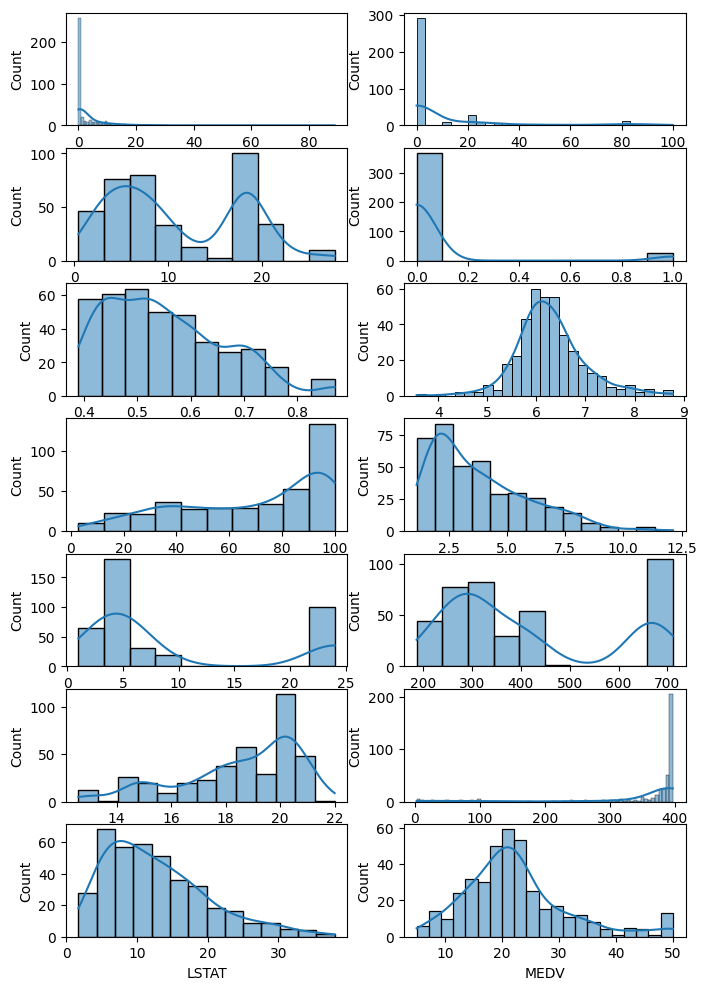

In [13]:
# Data před standardizací
pos = 1
fig = plt.figure(figsize=(8, 12))
for i in data.columns:
    ax = fig.add_subplot(7,2, pos)
    pos = pos + 1
    sns.histplot(data[i],ax=ax, kde=True)

In [ ]:
# Z-standardization
def rescale(X):
    mean = X.mean()
    std = X.std()
    scaled_X = [(i - mean)/std for i in X]
    return pd.Series(scaled_X)

In [ ]:
# Vytvoření nového datasetu se standardizovanými proměnnými
data_std = pd.DataFrame(columns=data.columns)
for i in data.columns:
    data_std[i] = rescale(data[i])

In [ ]:
# Popis nových proměnných
data_std.describe()

In [ ]:
# Zobrazení distribuce celočíselných hodnot s odhadem distribuční funkce
# Tvar distribuce nových proměnných je stejný jako u původních proměnných
# pouze jejich střední hodnota je nyní 0
pos = 1
fig = plt.figure(figsize=(8,12))
for i in data_std.columns:
    ax = fig.add_subplot(7,2, pos)
    pos = pos + 1
    sns.histplot(data_std[i],ax=ax, kde=True)

In [ ]:
# korelace nových dat
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
sns.heatmap(data_std.corr(),annot=True)

## 1.6 PCA

Zjednodušeně řečeno, PCA je matematický postup, který vezme několik lineárně korelovaných promměnných a vrátí několik nekorelovaných proměnných.

Často se používá při redukci dimenzionality pro snížení složitosti učebních modelů nebo pro vizualizaci vícerozměrných dat do 2D nebo 3D dat, což usnadňuje jejich vizualizaci.

Ale PCA není jen technika redukce dimenzionality.

**PCA použijeme pro redukci dimenzionality a zároveň pro odstranění multikolinearity**.

Analýza hlavních komponent (PCA) je statistický postup, který využívá ortogonální transformaci k převodu souboru pozorování případně korelovaných proměnných (entit, z nichž každá nabývá různých číselných hodnot) na soubor hodnot lineárně nekorelovaných proměnných, tzv. hlavních komponent. 

Tato transformace je definována tak, že první hlavní komponenta má co největší rozptyl (tj. odpovídá za co největší část variability v datech) a každá následující komponenta má zase co největší rozptyl za podmínky, že je ortogonální k předchozím komponentám. 

Výsledné vektory (z nichž každý je lineární kombinací proměnných a obsahuje n pozorování) jsou nekorelovanou ortogonální základní množinou. 

PCA je citlivá na relativní škálování původních proměnných.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Počet PCA komponent bude 13 stejně jako vstupních parametrů, výstupní MEDV odstraníme
pca = PCA(n_components=13)
X = data_std.drop('MEDV',axis=1)
X_pca = pca.fit_transform(X)

In [ ]:
# vytvoříme si nový dataset s proměnnými PCA a MEDV
data_std_pca = pd.DataFrame(X_pca,columns=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10','PCA11','PCA12','PCA13'])
data_std_pca['MEDV'] = data_std['MEDV']

In [ ]:
# korelační matice
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sns.heatmap(data_std_pca.corr(),annot=True)

V korelační matici je vidět, že PCA komponenty nejsou na sobě závislé.

MEDV je lineárně závislý na prvních 3 PCA proměnných. Pak lineární závislost velmi klesá.

In [ ]:
# Distribuční funkce PCA proměnných jsou odlišné od původních
pos = 1
fig = plt.figure(figsize=(12,16))
for i in data_std_pca.columns:
    ax = fig.add_subplot(7,2, pos)
    pos = pos + 1
    sns.histplot(data_std_pca[i],ax=ax, kde=True)

## 1.7 Lineární model ze všech PCA proměnných 

In [ ]:
# rozdělení dat na trénovací a testovací
X = np.array(data_std_pca.drop('MEDV',axis=1))
Y = np.array(data_std_pca['MEDV'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
# vytvoření lineárního modelu
lr = LinearRegression()
lr.fit(X_train, Y_train)

In [ ]:
# Posouzení modelu pro trénovací data
Y_pred = lr.predict(X_train)
r2 = r2_score(Y_train, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))

print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")

In [ ]:
# Posouzení modelu pro trénovací data
Y_pred = lr.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")

## 1.8 Lineární model ze 6 PCA proměnných 

In [ ]:
# Do modelu vstupuje pouze 6 prvních PCA proměnných
# Uděláme tedy redukci dimenzionality
lr = LinearRegression()
lr.fit(X_train[:,0:6], Y_train)

In [ ]:
# Posouzení modelu pro trénovací data
Y_pred = lr.predict(X_train[:,0:6])
r2 = r2_score(Y_train, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))

print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")

In [ ]:
# Posouzení modelu pro trénovací data
Y_pred = lr.predict(X_test[:,0:6])
r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")